In [1]:
import numpy as np
import gymnasium as gym

class Discretizer:
    def __init__(self, range=None, shape=None, scaler=(1,1,1,1)):
        if range is None or shape is None:
            self.find_params()
        else:
            self.shape = shape
            self.range = range

        self.bounds = list(zip(np.array(self.range[0])*np.array(scaler), np.array(self.range[1])*np.array(scaler)))
        self.intervals = [np.linspace(low, high, num) for (low, high), num in zip(self.bounds, self.shape)]

    def find_params(self):
        env = gym.make("CartPole-v1")

        obs, _ = env.reset() 
        hist = np.array([obs])

        policies = [lambda: 1, lambda: 0, lambda: np.random.randint(2)]
        
        for policy in policies:
            for _ in range(1000):
                terminated, truncated = False, False
                obs, _ = env.reset() 
                hist = np.append(hist, [obs], axis=0)
                while not (truncated or terminated):
                    obs, _, terminated, truncated, _ = env.step(policy())
                    hist = np.append(hist, [obs], axis=0)

        # for i in range(4):
        #     print(i, np.min(hist[:,i]), np.max(hist[:,i]), np.mean(hist[:,i]), np.std(hist[:,i]))

        self.range = list(zip(*[(np.min(hist[:,i]), np.max(hist[:,i])+1) for i in range(4)]))
        self.shape = [int(np.round( (np.abs(np.min(hist[:,i]))+np.abs(np.max(hist[:,i])))/np.std(hist[:,i]) )) for i in range(4)]

    def discretize_state(self, observation, scaler=None):
        if scaler is None:
            min_max = (np.array(observation) - np.array(self.range[0])) / (np.array(self.range[1]) - np.array(self.range[0]))
            # print(min_max)
            discretized_state = np.int_(min_max * np.array(self.shape))
        else:
            discretized_state = [np.digitize(obs_dim, obs_intervals) for obs_dim, obs_intervals in zip(observation*np.array(scaler), self.intervals)]
        return tuple(discretized_state)

In [2]:
def epsilon_greedy(S, Q, e):
    explore = np.random.choice([0,1], p=[e, 1-e])
    return (np.random.randint(0,2), np.argmax(Q[S]))[explore]

In [45]:
import gymnasium as gym

env = gym.make("CartPole-v1")


alpha, gamma, epsilon = .5, .9, .1
n_episodes = 500

# state_space_resolution = (5,5,5,5)
# state_space_scaler = (1,1e-38,1,1e-38)
state_scaler = (10,2,2,2)

# disc = Discretizer(env.observation_space, state_space_resolution, state_space_scaler)
# disc = Discretizer(range=s_range, shape=s_shape)
disc = Discretizer()

# Q = np.random.random((*[n+1 for n in state_space_resolution], 2))
# Q = np.random.random((*[n+1 for n in disc.shape], 2))
Q = np.zeros((*[n+1 for n in disc.shape], 2))
reults = []

for episode in range(n_episodes):
    terminated, truncated = False, False
    step = 0
    acum_r = 0

    observation, info = env.reset() 
    # S = disc.discretize_state(observation, state_scaler)
    S = disc.discretize_state(observation)
    # A = env.action_space.sample() 
    A = epsilon_greedy(S, Q, epsilon)

    while not (truncated or terminated):
        observation, R, terminated, truncated, _ = env.step(A)
        S_ = disc.discretize_state(observation, state_scaler)
        # S_ = disc.discretize_state(observation)
        # A_ = env.action_space.sample() 
        A_ = epsilon_greedy(S_, Q, epsilon)
        
        step += 1
        acum_r += R
        print(episode,step,S,A,R,S_,A_)
        print(observation)
        
        Q[(*S, A)] = Q[(*S, A)] + alpha*(R + gamma*Q[(*S_, A_)] - Q[(*S, A)])
        S, A = S_, A_


    reults.append(acum_r)

env.close()

0 1 (9, 2, 0, 2) 0 1.0 (10, 3, 1, 3) 0
[ 0.00725786 -0.15756099  0.00369535  0.34055975]
0 2 (10, 3, 1, 3) 0 1.0 (9, 2, 1, 3) 0
[ 0.00410664 -0.3527353   0.01050655  0.6344057 ]
0 3 (9, 2, 1, 3) 0 1.0 (9, 2, 1, 3) 0
[-0.00294807 -0.54800224  0.02319466  0.9303788 ]
0 4 (9, 2, 1, 3) 0 1.0 (8, 2, 1, 4) 0
[-0.01390811 -0.7434294   0.04180223  1.2302593 ]
0 5 (8, 2, 1, 4) 0 1.0 (7, 1, 2, 4) 0
[-0.0287767  -0.9390635   0.06640742  1.5357404 ]
0 6 (7, 1, 2, 4) 0 1.0 (6, 1, 2, 4) 0
[-0.04755797 -1.1349192   0.09712223  1.8483858 ]
0 7 (6, 1, 2, 4) 0 1.0 (5, 1, 2, 5) 0
[-0.07025635 -1.3309672   0.13408995  2.169581  ]
0 8 (5, 1, 2, 5) 0 1.0 (3, 0, 2, 5) 0
[-0.0968757  -1.5271188   0.17748156  2.5004716 ]
0 9 (3, 0, 2, 5) 0 1.0 (1, 0, 2, 5) 0
[-0.12741807 -1.7232088   0.22749099  2.8418922 ]
1 1 (9, 2, 0, 2) 0 1.0 (11, 2, 1, 3) 0
[ 0.02836886 -0.23538734 -0.01396625  0.264696  ]
1 2 (11, 2, 1, 3) 0 1.0 (11, 2, 1, 3) 0
[ 0.02366111 -0.43030718 -0.00867233  0.5529413 ]
1 3 (11, 2, 1, 3) 0 1.0 (10

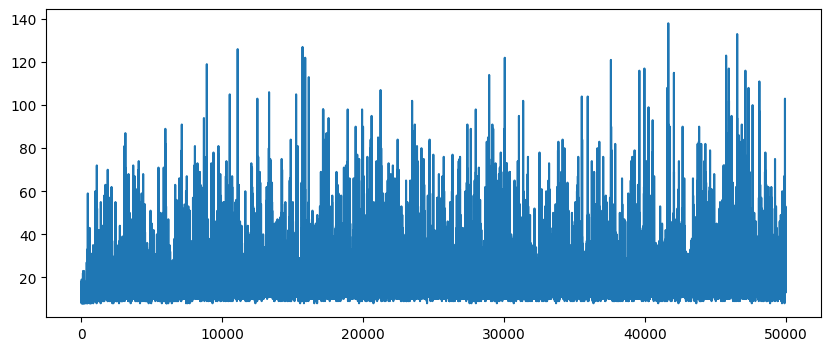

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(10, 4))
axs.plot(reults)

In [6]:
Q.shape

(32, 7, 6, 6, 2)